In [1]:
# Install all required packages
!pip install numpy \
            faiss-cpu \
            sentence-transformers \
            chromadb \
            pandas \
            matplotlib \
            scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import chromadb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


c:\Users\Bob\Desktop\10Acadamy\week6\chatbot-finance\chat-bot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded: {model}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")


Model loaded: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
Embedding dimension: 384


In [4]:
# Extended dataset of landmarks
landmarks_data = {
    'name': [
        'Eiffel Tower',
        'Great Wall of China',
        'Colosseum',
        'Statue of Liberty',
        'Golden Gate Bridge',
        'Taj Mahal',
        'Machu Picchu',
        'Christ the Redeemer',
        'Petra',
        'Sydney Opera House',
        'Big Ben',
        'Burj Khalifa',
        'Sagrada Familia',
        'Mount Rushmore',
        'Pyramids of Giza'
    ],
    'description': [
        "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.",
        "The Great Wall of China is a series of fortifications made of stone, brick, tamped earth, wood, and other materials.",
        "The Colosseum is an oval amphitheatre in the centre of the city of Rome, Italy.",
        "The Statue of Liberty is a colossal neoclassical sculpture on Liberty Island in New York Harbor in New York City.",
        "The Golden Gate Bridge is a suspension bridge spanning the Golden Gate, the one-mile-wide strait connecting San Francisco Bay and the Pacific Ocean.",
        "The Taj Mahal is an ivory-white marble mausoleum on the south bank of the Yamuna river in the Indian city of Agra.",
        "Machu Picchu is a 15th-century Inca citadel located in the Eastern Cordillera of southern Peru.",
        "Christ the Redeemer is an Art Deco statue of Jesus Christ in Rio de Janeiro, Brazil.",
        "Petra is a historical and archaeological city in southern Jordan famous for its rock-cut architecture.",
        "The Sydney Opera House is a multi-venue performing arts centre on Sydney Harbour in Sydney, Australia.",
        "Big Ben is the nickname for the Great Bell of the clock at the north end of the Palace of Westminster in London.",
        "The Burj Khalifa is a skyscraper in Dubai, United Arab Emirates, and is the tallest building in the world.",
        "The Sagrada Familia is a large unfinished Roman Catholic minor basilica in Barcelona, Spain.",
        "Mount Rushmore features 60-foot sculptures of the heads of four United States presidents carved into granite.",
        "The Pyramids of Giza are ancient pyramid structures located on the outskirts of Cairo, Egypt."
    ],
    'location': [
        'Paris, France',
        'China',
        'Rome, Italy',
        'New York, USA',
        'San Francisco, USA',
        'Agra, India',
        'Peru',
        'Rio de Janeiro, Brazil',
        'Jordan',
        'Sydney, Australia',
        'London, UK',
        'Dubai, UAE',
        'Barcelona, Spain',
        'South Dakota, USA',
        'Cairo, Egypt'
    ],
    'continent': [
        'Europe',
        'Asia',
        'Europe',
        'North America',
        'North America',
        'Asia',
        'South America',
        'South America',
        'Asia',
        'Australia',
        'Europe',
        'Asia',
        'Europe',
        'North America',
        'Africa'
    ]
}

# Create DataFrame
df_landmarks = pd.DataFrame(landmarks_data)
print(f"Total landmarks: {len(df_landmarks)}")
df_landmarks.head()


Total landmarks: 15


,name,description,location,continent
0,Eiffel Tower,The Eiffel Tower is a wrought-iron lattice tow...,"Paris, France",Europe
1,Great Wall of China,The Great Wall of China is a series of fortifi...,China,Asia
2,Colosseum,The Colosseum is an oval amphitheatre in the c...,"Rome, Italy",Europe
3,Statue of Liberty,The Statue of Liberty is a colossal neoclassic...,"New York, USA",North America
4,Golden Gate Bridge,The Golden Gate Bridge is a suspension bridge ...,"San Francisco, USA",North America


In [5]:
# Load only necessary columns to save memory
df_main = pd.read_csv('../data/filtered_complaints.csv', usecols=[
    'Date received', 'Product', 'Consumer complaint narrative', 'Complaint ID'
])

In [6]:
df_main['Consumer complaint narrative']

0         A XXXX XXXX card was opened under my name by a...
1         I made the mistake of using my wellsfargo debi...
2         Dear CFPB, I have a secured credit card with c...
3         I have a Citi rewards cards. The credit balanc...
4         b'I am writing to dispute the following charge...
                                ...                        
318169    US bank is holding a {$200.00} Check Deposit w...
318170    I had over 80 small charges, many were for the...
318171    I moved into XXXX XXXX XXXX  XXXX, owned, and ...
318172    Hello, I'm an XXXX  of XXXX XXXX company that ...
318173    I already have a case XXXX, but it should not ...
Name: Consumer complaint narrative, Length: 318174, dtype: object

In [7]:
# Generate embeddings for all descriptions
descriptions = df_main['Consumer complaint narrative'].tolist()
embeddings = model.encode(descriptions)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Each embedding has {embeddings.shape[1]} dimensions")


Embeddings shape: (318174, 384)
Each embedding has 384 dimensions


In [15]:
import numpy as np

# Save embeddings
np.save("../data/embeddings/complaint_embeddings.npy", embeddings)

# Save matching dataframe rows (optional but useful)
df_main[['Consumer complaint narrative', 'Product']].to_csv("../data/processed/filtered_complaints.csv", index=False)


In [11]:
df_main.columns


Index(['Date received', 'Product', 'Consumer complaint narrative',
       'Complaint ID'],
      dtype='object')

Batches: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


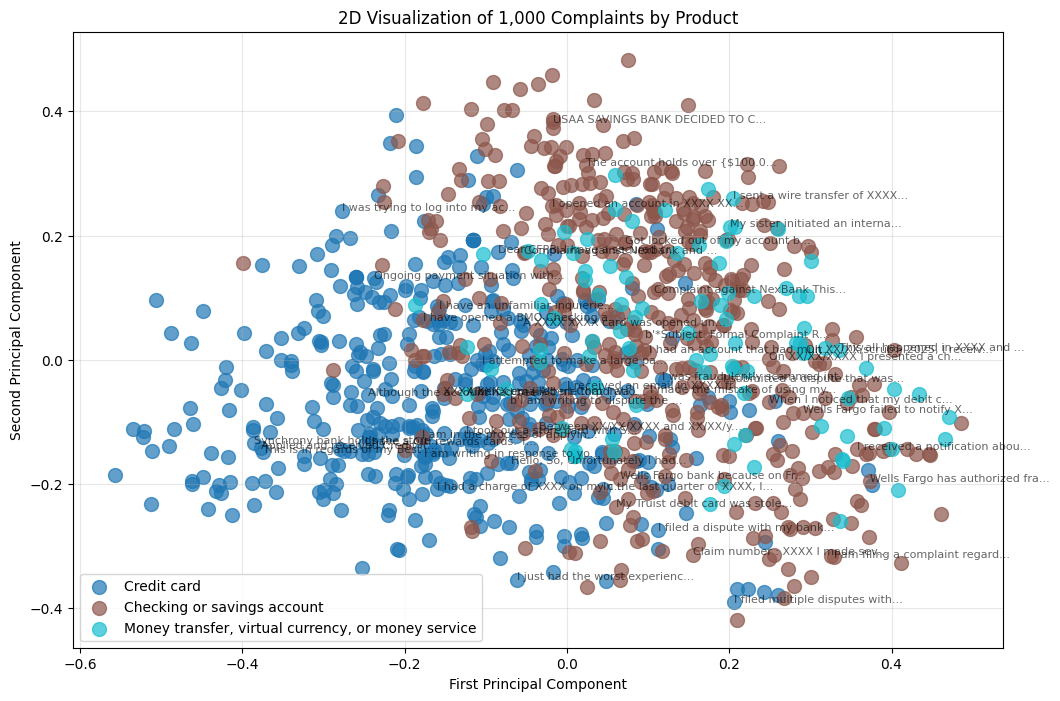

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Step 1: Drop rows with missing values and take only 1,000
df_filtered = df_main[['Consumer complaint narrative', 'Product']].dropna().head(1000)

# Step 2: Generate sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_filtered['Consumer complaint narrative'].tolist(), show_progress_bar=True)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Step 4: Plot the embeddings
plt.figure(figsize=(12, 8))
unique_products = df_filtered['Product'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_products))

for i, product in enumerate(unique_products):
    mask = df_filtered['Product'] == product
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                color=colors(i), label=product, s=100, alpha=0.7)

# Step 5: Annotate first few points
for i, text in enumerate(df_filtered['Consumer complaint narrative'][:50]):
    plt.annotate(text[:30] + "...", (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=8, alpha=0.6)

plt.title('2D Visualization of 1,000 Complaints by Product')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [16]:
# Create a FAISS index
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance metric

# Add embeddings to the index
index.add(embeddings)

print(f"FAISS index created with {index.ntotal} vectors")
print(f"Index type: {type(index)}")


FAISS index created with 1000 vectors
Index type: <class 'faiss.swigfaiss_avx2.IndexFlatL2'>


In [23]:
def search_faiss(query, k=5):
    """Search for similar consumer complaints using FAISS"""
    # Encode the query
    query_embedding = model.encode([query])

    # Search
    distances, indices = index.search(query_embedding, k)

    # Display results
    print(f"Query: '{query}'")
    print(f"\nTop {k} similar complaints:")
    print("-" * 60)

    results = []
    for i in range(k):
        idx = indices[0][i]
        dist = distances[0][i]

        complaint = df_main.iloc[idx]['Consumer complaint narrative']
        product = df_main.iloc[idx]['Product']
        complaint_id = df_main.iloc[idx].get('Complaint ID', 'N/A')
        date_received = df_main.iloc[idx].get('Date received', 'N/A')

        print(f"{i+1}. Product: {product}")
        print(f"   Complaint ID: {complaint_id}")
        print(f"   Date Received: {date_received}")
        print(f"   Distance: {dist:.4f}")
        print(f"   Complaint: {complaint[:200]}...")
        print()

        results.append({
            'Rank': i+1,
            'Product': product,
            'Complaint ID': complaint_id,
            'Date received': date_received,
            'Distance': dist,
            'Complaint snippet': complaint[:200] + "..."
        })

    return pd.DataFrame(results)


In [25]:
queries = [
    "system not working",
    "loan payment issues",
    "problem with money transfers",
    "denied access to savings account"
]

for query in queries:
    results_df = search_faiss(query, k=3)
    print("=" * 60)
    print()  # Blank line between query outputs


Query: 'system not working'

Top 3 similar complaints:
------------------------------------------------------------
1. Product: Checking or savings account
   Complaint ID: 13954175
   Date Received: 2025-06-07
   Distance: 1.4755
   Complaint: XXXX MONDAY! 
Deposited XXXX checks from state of California, a back pay checks since XXXX of last year. Around XXXX something with a XXXX limit if you do online check deposit. 

XXXX Checking my acco...

2. Product: Checking or savings account
   Complaint ID: 13912495
   Date Received: 2025-06-05
   Distance: 1.4872
   Complaint: I have had a checking account with US Bank for over 15 years. This morning I tried to access my account and online banking had no information about my account as if it never existed. It was gone the b...

3. Product: Checking or savings account
   Complaint ID: 14004892
   Date Received: 2025-06-10
   Distance: 1.4910
   Complaint: I had funds in my account and now its closed with no explanation. Not an email or a let

In [28]:
import faiss

embedding_dim = embeddings.shape[1]

# Create different FAISS index types
index_types = {
    'Flat L2': faiss.IndexFlatL2(embedding_dim),
    'Flat IP (Inner Product)': faiss.IndexFlatIP(embedding_dim),
    # You can add other index types here if you want
}

# Add embeddings to all indices
for name, idx in index_types.items():
    idx.add(embeddings)

# Query to test
query = "system not working"
query_embedding = model.encode([query])

print(f"Query: '{query}'\n")

for name, idx in index_types.items():
    print(f"{name} Index:")
    distances, indices = idx.search(query_embedding, 3)
    for i in range(3):
        idx_result = indices[0][i]
        dist = distances[0][i]

        complaint = df_main.iloc[idx_result]['Consumer complaint narrative']
        product = df_main.iloc[idx_result]['Product']

        print(f"  {i+1}. Product: {product} (Distance: {dist:.4f})")
        print(f"     Complaint snippet: {complaint[:100]}...")
    print()


Query: 'system not working'

Flat L2 Index:
  1. Product: Checking or savings account (Distance: 1.4755)
     Complaint snippet: XXXX MONDAY! 
Deposited XXXX checks from state of California, a back pay checks since XXXX of last y...
  2. Product: Checking or savings account (Distance: 1.4872)
     Complaint snippet: I have had a checking account with US Bank for over 15 years. This morning I tried to access my acco...
  3. Product: Checking or savings account (Distance: 1.4910)
     Complaint snippet: I had funds in my account and now its closed with no explanation. Not an email or a letter was sent ...

Flat IP (Inner Product) Index:
  1. Product: Checking or savings account (Distance: 0.2622)
     Complaint snippet: XXXX MONDAY! 
Deposited XXXX checks from state of California, a back pay checks since XXXX of last y...
  2. Product: Checking or savings account (Distance: 0.2564)
     Complaint snippet: I have had a checking account with US Bank for over 15 years. This morning I tried 

ChromaDB


In [29]:
import chromadb

# Initialize ChromaDB client
client = chromadb.Client()

# Delete existing collection if it exists (safely)
try:
    client.delete_collection("complaints_collection")
    print("Existing collection 'complaints_collection' deleted.")
except Exception as e:
    print("No existing collection to delete or error:", e)

# Create a new collection for complaints
collection = client.create_collection(
    name="complaints_collection",
    metadata={"description": "A collection of consumer complaints"}
)

print(f"Created collection: {collection.name}")
print(f"Collection metadata: {collection.metadata}")


No existing collection to delete or error: Collection [complaints_collection] does not exists
Created collection: complaints_collection
Collection metadata: {'description': 'A collection of consumer complaints'}


In [34]:
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Limit to first 100,000 rows
df_subset = df_main.head(100000)

# Initialize ChromaDB client and collection
client = chromadb.Client()

try:
    client.delete_collection("complaints_collection")
except Exception:
    pass

collection = client.create_collection(
    name="complaints_collection",
    metadata={"description": "A collection of consumer complaints"}
)

print(f"✅ Created collection: {collection.name}")

# Batch embedding generation
def generate_embeddings_in_batches(texts, batch_size=1000):
    all_embeddings = []
    for start_idx in range(0, len(texts), batch_size):
        end_idx = min(start_idx + batch_size, len(texts))
        batch_texts = texts[start_idx:end_idx]
        print(f"🔁 Encoding batch {start_idx} to {end_idx}...")
        batch_embeddings = model.encode(batch_texts)
        all_embeddings.append(batch_embeddings)
    return np.vstack(all_embeddings)

# Add to ChromaDB in batches
def add_to_chroma_in_batches(embeddings, documents, metadatas, ids, batch_size=5000):
    for start_idx in range(0, len(documents), batch_size):
        end_idx = min(start_idx + batch_size, len(documents))
        print(f"📦 Adding batch {start_idx} to {end_idx} to ChromaDB...")
        collection.add(
            embeddings=embeddings[start_idx:end_idx],
            documents=documents[start_idx:end_idx],
            metadatas=metadatas[start_idx:end_idx],
            ids=ids[start_idx:end_idx]
        )

# Prepare data from subset
texts = df_subset['Consumer complaint narrative'].tolist()
ids = df_subset['Complaint ID'].astype(str).tolist()
metadatas = [
    {'product': row['Product'], 'date_received': row['Date received']}
    for _, row in df_subset.iterrows()
]

# Step 1: Generate embeddings
embeddings = generate_embeddings_in_batches(texts, batch_size=1000)

# Step 2: Add to ChromaDB
add_to_chroma_in_batches(
    embeddings=embeddings,
    documents=texts,
    metadatas=metadatas,
    ids=ids,
    batch_size=5000
)

print(f"✅ Finished! Total documents added to ChromaDB: {collection.count()}")


✅ Created collection: complaints_collection
🔁 Encoding batch 0 to 1000...
🔁 Encoding batch 1000 to 2000...
🔁 Encoding batch 2000 to 3000...
🔁 Encoding batch 3000 to 4000...
🔁 Encoding batch 4000 to 5000...
🔁 Encoding batch 5000 to 6000...
🔁 Encoding batch 6000 to 7000...
🔁 Encoding batch 7000 to 8000...
🔁 Encoding batch 8000 to 9000...
🔁 Encoding batch 9000 to 10000...
🔁 Encoding batch 10000 to 11000...
🔁 Encoding batch 11000 to 12000...
🔁 Encoding batch 12000 to 13000...
🔁 Encoding batch 13000 to 14000...
🔁 Encoding batch 14000 to 15000...
🔁 Encoding batch 15000 to 16000...
🔁 Encoding batch 16000 to 17000...
🔁 Encoding batch 17000 to 18000...
🔁 Encoding batch 18000 to 19000...
🔁 Encoding batch 19000 to 20000...
🔁 Encoding batch 20000 to 21000...
🔁 Encoding batch 21000 to 22000...
🔁 Encoding batch 22000 to 23000...
🔁 Encoding batch 23000 to 24000...
🔁 Encoding batch 24000 to 25000...
🔁 Encoding batch 25000 to 26000...
🔁 Encoding batch 26000 to 27000...
🔁 Encoding batch 27000 to 28000..

In [36]:
import pickle
import os

# Create a folder to store saved files
os.makedirs("saved_data", exist_ok=True)

# Save embeddings as .npy
np.save("../data/embeddings/embeddings_chromadb.npy", embeddings)

# Save texts, metadatas, and ids as .pkl
with open("saved_data/texts.pkl", "wb") as f:
    pickle.dump(texts, f)

with open("saved_data/metadatas.pkl", "wb") as f:
    pickle.dump(metadatas, f)

with open("saved_data/ids.pkl", "wb") as f:
    pickle.dump(ids, f)

print("✅ Saved embeddings and related data to the 'saved_data' folder.")


✅ Saved embeddings and related data to the 'saved_data' folder.


In [37]:
# Assuming embeddings.shape[0] == 1000
subset_df = df_main.iloc[:1000]

ids = subset_df['Complaint ID'].astype(str).tolist()
documents = subset_df['Consumer complaint narrative'].tolist()
metadatas = [
    {'product': row['Product'], 'date_received': row['Date received']}
    for _, row in subset_df.iterrows()
]

collection.add(
    embeddings=embeddings,
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

print(f"Added {collection.count()} documents to ChromaDB")


ValueError: Unequal lengths for fields: ids: 1000, metadatas: 1000, embeddings: 100000, documents: 1000 in add.

In [38]:
def search_chromadb(query, n_results=3, where=None):
    """Search ChromaDB with optional metadata filtering"""
    query_embedding = model.encode([query])

    results = collection.query(
        query_embeddings=query_embedding,
        n_results=n_results,
        where=where
    )

    print(f"Query: '{query}'")
    if where:
        print(f"Filter: {where}")
    print(f"\nTop {n_results} results:")
    print("-" * 60)

    for i in range(len(results['ids'][0])):
        print(f"{i+1}. Product: {results['metadatas'][0][i]['product']}")
        print(f"   Complaint ID: {results['ids'][0][i]}")
        print(f"   Date Received: {results['metadatas'][0][i]['date_received']}")
        print(f"   Distance: {results['distances'][0][i]:.4f}")
        print(f"   Complaint: {results['documents'][0][i][:300]}...")
        print()


In [39]:
# Basic query
search_chromadb("unauthorized credit card charges")
print("=" * 60)

# Query filtered by product
search_chromadb("loan payment issues", where={"product": "Credit card"})
print("=" * 60)

# Another query
search_chromadb("problem with money transfers")


Query: 'unauthorized credit card charges'

Top 3 results:
------------------------------------------------------------
1. Product: Credit card
   Complaint ID: 12508103
   Date Received: 2025-03-16
   Distance: 0.4363
   Complaint: Unauthorized charges on credit account statement shows XXXX XXXX XXXX XXXX XXXX XXXX...

2. Product: Credit card
   Complaint ID: 11181815
   Date Received: 2024-12-17
   Distance: 0.4601
   Complaint: For a few years I have been having problems with my card being charged for purchases I haven't authorized. It got so bad that I have had to change my card 4 times and the same charges continues to show up on my card. I even disputed the charges and they still continue to reoccur. I was told at XXXX ...

3. Product: Checking or savings account
   Complaint ID: 11645641
   Date Received: 2025-01-18
   Distance: 0.4903
   Complaint: My card from XXXX XXXX XXXX was charged multiple times from an unauthorized merchants and people from different states and also had 

In [40]:
import pandas as pd

comparison_data = {
    'Feature': ['Speed', 'Metadata Support', 'Persistence', 'Ease of Use',
                'Scalability', 'GPU Support', 'Query Flexibility', 'Memory Usage'],
    'FAISS': ['Very Fast', 'No', 'Manual', 'Medium',
              'Excellent', 'Yes', 'Limited', 'Low'],
    'ChromaDB': ['Fast', 'Yes', 'Built-in', 'Easy',
                 'Good', 'No', 'High', 'Medium']
}

comparison_df = pd.DataFrame(comparison_data)
print("FAISS vs ChromaDB Comparison:")
print(comparison_df.to_string(index=False))


FAISS vs ChromaDB Comparison:
          Feature     FAISS ChromaDB
            Speed Very Fast     Fast
 Metadata Support        No      Yes
      Persistence    Manual Built-in
      Ease of Use    Medium     Easy
      Scalability Excellent     Good
      GPU Support       Yes       No
Query Flexibility   Limited     High
     Memory Usage       Low   Medium


In [41]:
import time
import numpy as np
import pandas as pd

# Make sure your model, FAISS index, and ChromaDB collection are already initialized

# Test queries
test_queries = [
    "ancient monuments",
    "modern architecture",
    "famous bridges",
    "religious buildings",
    "tourist attractions"
]

# Measure FAISS performance
faiss_times = []
for query in test_queries:
    query_embedding = model.encode([query])

    start_time = time.time()
    distances, indices = index.search(query_embedding, 3)
    faiss_time = time.time() - start_time
    faiss_times.append(faiss_time)

# Measure ChromaDB performance
chroma_times = []
for query in test_queries:
    query_embedding = model.encode([query])

    start_time = time.time()
    results = collection.query(query_embeddings=query_embedding, n_results=3)
    chroma_time = time.time() - start_time
    chroma_times.append(chroma_time)

# Display results
performance_df = pd.DataFrame({
    'Query': test_queries,
    'FAISS Time (ms)': [t * 1000 for t in faiss_times],
    'ChromaDB Time (ms)': [t * 1000 for t in chroma_times]
})

print("Performance Comparison (search time in milliseconds):")
print(performance_df.to_string(index=False))
print(f"\nAverage FAISS time: {np.mean(faiss_times) * 1000:.2f} ms")
print(f"Average ChromaDB time: {np.mean(chroma_times) * 1000:.2f} ms")


Performance Comparison (search time in milliseconds):
              Query  FAISS Time (ms)  ChromaDB Time (ms)
  ancient monuments         1.551151            2.802849
modern architecture         0.205755            1.843452
     famous bridges         0.147104            2.874613
religious buildings         0.154018            2.370596
tourist attractions         0.159264            2.858400

Average FAISS time: 0.44 ms
Average ChromaDB time: 2.55 ms
